# A VI-ME-BA-BAR workflow

In [1]:
# Load general libraries
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2

# Step 1: {VI}sualization and data preprocessing 
At this stage we do not expect you to be able to write the code that we give you in the next two cells, but check it out and try to understand it.

In [2]:
def get_files(datadir, type = 'a'):
    ''' Function that gets all the files as a list. '''
    file_list = list()
    for root, dirs, files in os.walk(datadir):
        for name in files:
            if not re.search('.ipynb|.DS_Store', name) and re.search(type, name):
                file_list.append(os.path.join(root, name))
    return sorted(file_list, key = str)

def get_image(path):
    ''' Function that gets an image and set its background to transparent. '''
    img = Image.open(path)
    data=img.getdata()  # Get a list of tuples
    newData=[]
    for a in data:
        a=a[:3] # Shorten to RGB
        if np.mean(np.array(a)) == 255: # the background is white
            a=a+(0,) # Put a transparent value in A channel (the fourth one)
        else:
            a=a+(255,) # Put a non- transparent value in A channel
        newData.append(a)
    img.putdata(newData) # Get new img ready
    return img

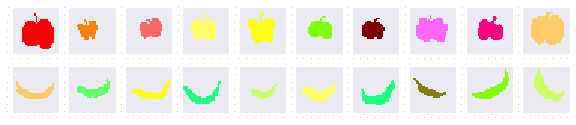

In [3]:
data_dir = './mini-dataset'
a_files = get_files(data_dir, 'a')
b_files = get_files(data_dir, 'b')
columns = 10
rows = len(a_files+b_files)/columns
fig=plt.figure(figsize=(columns, rows))
k=1
for filename in a_files+b_files:
    img=get_image(filename)
    fig.add_subplot(rows, columns, k)
    plt.imshow(img) 
    plt.tick_params(axis='both', labelsize=0, length = 0)
    plt.grid(b=False)
    k=k+1

## Preprocessing and feature extraction
Data often come already in a feature representation, but not always. In [01-images.ipynb](01-images.ipynb), we guide you step by step through two simple feature extraction processes.

For convenience, we repackage them as reusable functions:

In [13]:
def extract_redness(M):
    R = 1.*M[:,:,0]; G = 1.*M[:,:,1]; B = 1.*M[:,:,2]
    D = R-(G+B)/2
    V = (R+G+B)/3
    return np.mean(D[V!=0])

def extract_elongation(M):
    R = 1.*M[:,:,0]; G = 1.*M[:,:,1]; B = 1.*M[:,:,2]
    V = (R+G+B)/3
    imw, imh = V.shape
    V0 = np.mean(V, axis=0)
    V1 = np.mean(V, axis=1)
    V0_idx = [i for i in range(imw) if V0[i]!=255]
    V1_idx = [i for i in range(imh) if V1[i]!=255]
    w = max(V0_idx)-min(V0_idx)
    h = max(V1_idx)-min(V1_idx)
    return w/h
    
def extract_features(M, verbose = False):
    '''
    Take a RGBA numpy array M as input 
    and return two features of the foreground: 
    redness and elongation.

    verbose is just a flag that can be turned on for debbuging purposes.
    '''
    redness = extract_redness(M)
    elongation = extract_elongation(M)
    if verbose:
        print('redness={0:5.2f}'.format(redness))
        print('elongation={0:5.2f}'.format(elongation))
    return [redness, elongation]

## Preprocess and visualize all the data
At this stage we do not expect you to be able to write the code that we give you in the next few cells, but check it out and try to understand it.

In [14]:
# Create a big data matrix with a_files and b_files
verbose = False
n = len(a_files)
_X = np.zeros([2*n, 2])
Y = np.zeros([2*n, 1])
# Read and convert a_files
for i in range(n):
    if verbose: print(a_files[i])
    img=get_image(a_files[i])
    M = np.array(img)
    _X[i, :] = extract_features(M, verbose)
    Y[i] = 1 # Apples are labeled 1
# Read and convert b_files
for i in range(n):
    if verbose: print(b_files[i])
    img=get_image(b_files[i])
    M = np.array(img)
    _X[n+i, :] = extract_features(M, verbose)
    Y[n+i] = -1 # Bananas are labeled -1

In [15]:
# Show the values in X and Y
XY = pd.DataFrame(np.append(_X, Y, axis=1), columns=['redness', 'elongation', 'fruit'])
XY

,redness,elongation,fruit
0,84.012207,0.869565,1.0
1,21.860352,1.000000,1.0
2,22.558594,1.076923,1.0
3,14.941406,0.888889,1.0
4,27.993164,0.894737,1.0
5,-0.563965,1.071429,1.0
6,18.975586,1.076923,1.0
7,20.025879,1.176471,1.0
8,35.056641,1.066667,1.0
9,37.776367,1.000000,1.0


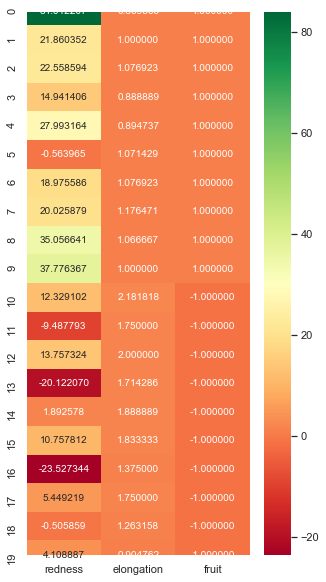

In [16]:
# Show the values as a heat map
XY = pd.DataFrame(np.append(_X, Y, axis=1), columns=['redness', 'elongation', 'fruit'])
fig=plt.figure(figsize=(5,10))
sns.heatmap(XY, annot=True, fmt='f', cmap='RdYlGn') 

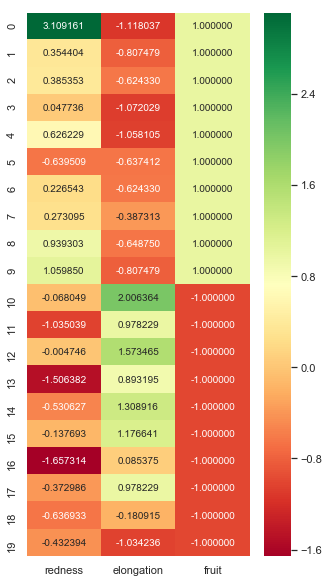

In [14]:
# For better rendering and improved results, the features are standardized.
# This means that for each column vector we subtract the mean and divide by the standard deviation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X = scaler.fit_transform(_X)
XY = pd.DataFrame(np.append(X, Y, axis=1), columns=['redness', 'elongation', 'fruit'])
fig=plt.figure(figsize=(5,10))
sns.heatmap(XY, annot=True, fmt='f', cmap='RdYlGn')

In [97]:
# Make one training-test split in a stratified manner 
from sklearn.model_selection import StratifiedShuffleSplit
SSS = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in SSS.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]

TRAIN: [14 19  2 11  3 18 12  5  9  1] TEST: [ 0 17  4 13  6  8  7 16 10 15]


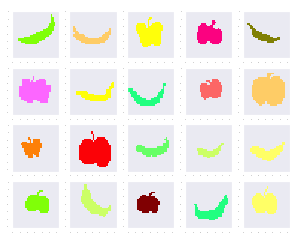

In [131]:
columns = 5
rows = len(a_files+b_files)/columns
fig=plt.figure(figsize=(columns, rows))
F = np.array(a_files + b_files)
k=1
for filename in np.concatenate((F[train_index],F[test_index])):
    img=get_image(filename)
    fig.add_subplot(rows, columns, k)
    plt.imshow(img) 
    plt.tick_params(axis='both', labelsize=0, length = 0)
    plt.grid(b=False)
    k=k+1

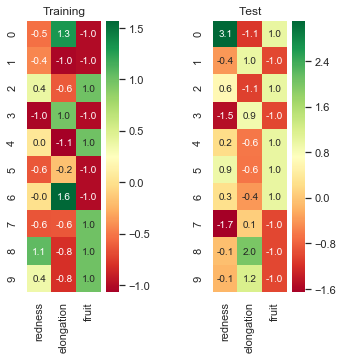

In [98]:
# Plot training and test data as heat maps
XY_train = pd.DataFrame(np.append(Xtrain, Ytrain, axis=1), columns=['redness', 'elongation', 'fruit'])
XY_test = pd.DataFrame(np.append(Xtest, Ytest, axis=1), columns=['redness', 'elongation', 'fruit'])
fig=plt.figure(figsize=(5,5))
fig.subplots_adjust(wspace=1)
ax_tr = fig.add_subplot(1, 2, 1)
sns.heatmap(XY_train, annot=True, fmt='.1f', cmap='RdYlGn')
ax_tr.title.set_text('Training')
ax_te = fig.add_subplot(1, 2, 2)
sns.heatmap(XY_test, annot=True, fmt='.1f', cmap='RdYlGn')
ax_te.title.set_text('Test')

Text(0, 0.5, 'Elongation')

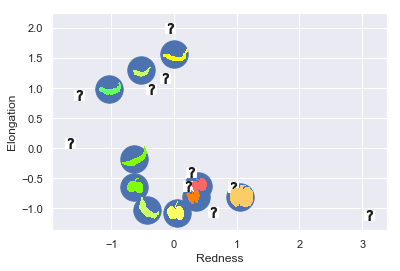

In [99]:
# Plot training and test data as scatter plots
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots()

# Plot training examples
x = X[train_index,0]
y = X[train_index,1]
f = F[train_index]
ax.scatter(x, y, s=750, marker='o') 

for x0, y0, path in zip(x, y, f):
    ab = AnnotationBbox(OffsetImage(get_image(path)), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
# Plot UNLABELED test examples
x = X[test_index,0]
y = X[test_index,1]
f = F[test_index]
ax.scatter(x, y, s=100, marker='s', c='w') 
ax.scatter(x, y, s=100, marker='$?$', c='k') 

plt.xlabel('Redness')
plt.ylabel('Elongation')

# Step 2: {ME}tric definition

### Question 8: Error rate
Write a function that implements the error rate metric. Follow this template:

    def error_rate(solution, prediction):
    # Put your code here.
    return e
    
Then write unit tests what check that the error rate between `solution=Ytrain` and `prediction=Ytrain` is zero, that between `solution=Ytrain` and `prediction=np.zeros(Ytrain.shape)` is one and the between `solution=Ytrain` and `prediction=np.ones(Ytrain.shape)` is 0.5.

In [100]:
# Solution to question 8
def error_rate(solution, prediction):
    '''Compute the error rate between two vectors.'''
    e = np.mean(solution!=prediction)
    return e

assert(error_rate(Ytrain, Ytrain) == 0)
assert(error_rate(Ytrain, np.zeros(Ytrain.shape)) == 1)
assert(error_rate(Ytrain, np.ones(Ytrain.shape)) == 0.5)

### Question 9: Accuracy score
The library `scikit_learn` also called `sklearn` has a function `accuracy_score`. Check that `error_rate` = `1-accuracy_score` using the same examples as above. As part of this question you need to first figure out how to import the function `accuracy_score`. Look this up on the Internet.

In [101]:
# Solution to question 9
from sklearn.metrics import accuracy_score
assert(error_rate(Ytrain, Ytrain) == 1-accuracy_score(Ytrain, Ytrain))
assert(error_rate(Ytrain, np.zeros(Ytrain.shape)) == 1-accuracy_score(Ytrain, np.zeros(Ytrain.shape)))
assert(error_rate(Ytrain, np.ones(Ytrain.shape)) == 1-accuracy_score(Ytrain, np.ones(Ytrain.shape)))

# Step 3: {BA}seline results
The 1-nearest neighbor classifier is a nice and simple method. Luckily it is implemented in `scikit-learn`. You may also want to implement it yourself as part of your project.

### Question 10: 1-nearest-neighbor classifier
Import the `KNeighborsClassifier` classifier from `scikit-learn`. Set the number of neighbors to one. Train a model with `Xtrain` by calling the method `fit`. Then use the trained model to create two vectors of prediction `Ytrain_predicted` and `Ytest_predicted` by calling the method `predict`. Compute `e_tr`, the training error rate, and `e_tr` the test error rate.

WARNING: `scikit-learn` uses lists for prediction labels instead of column vectors. You will have to replace `Ytrain` by `Ytrain.ravel()` and `Ytest` by `Ytest.ravel()` to avoid an error message and wrong error rates.

In [102]:
# Solution to question 10
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(Xtrain, Ytrain.ravel()) 
Ytrain_predicted = neigh.predict(Xtrain)
Ytest_predicted = neigh.predict(Xtest)
e_tr = error_rate(Ytrain.ravel(), Ytrain_predicted)
e_te = error_rate(Ytest.ravel(), Ytest_predicted)
print(e_tr, e_te)

0.0 0.0


### Question 11: Confusion matrix
Extract the variables `tn`, `fp`, `fn`, `tp` (true negative, false positive, false negative, and true positive) using the `confusion_matrix` function of `scikit_learn`, for test data predictions.

In [103]:
# Solution to question 11
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Ytest.ravel(), Ytest_predicted).ravel()
print(tn, fp, fn, tp)

5 0 0 5


### Here we overlay the predictions on test examples on the scatter plot ...

Text(0, 0.5, 'Elongation')

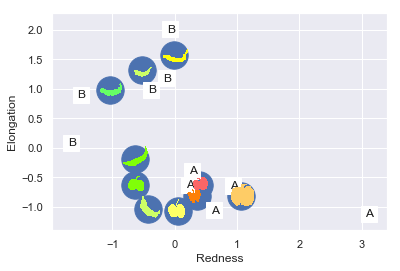

In [104]:
fig, ax = plt.subplots()

# Plot training examples
x = X[train_index,0]
y = X[train_index,1]
f = F[train_index]
ax.scatter(x, y, s=750, marker='o') 

for x0, y0, path in zip(x, y, f):
    ab = AnnotationBbox(OffsetImage(get_image(path)), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Plot test examples with predicted labels
fruit = np.array(['B', 'A'])
x = X[test_index,0]
y = X[test_index,1]
label = (Ytest_predicted+1)/2
ax.scatter(x, y, s=250, marker='s', color='w') 
for x0, y0, lbl in zip(x, y, label):
    ax.text(x0-0.05, y0-0.05, fruit[int(lbl)], color="k", fontsize=12)
    
plt.xlabel('Redness')
plt.ylabel('Elongation')

## ... and we show the "ground truth"

Text(0, 0.5, 'Elongation')

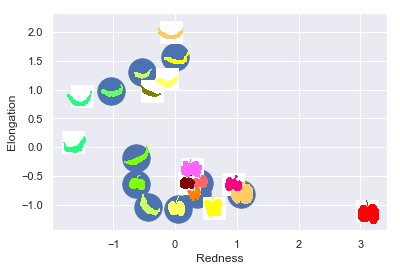

In [105]:
fig, ax = plt.subplots()

# Plot training examples
x = X[train_index,0]
y = X[train_index,1]
f = F[train_index]
ax.scatter(x, y, s=750, marker='o') 

for x0, y0, path in zip(x, y, f):
    ab = AnnotationBbox(OffsetImage(get_image(path)), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
# Plot test examples
x = X[test_index,0]
y = X[test_index,1]
f = F[test_index]
ax.scatter(x, y, s=500, marker='s', color='w') 

for x0, y0, path in zip(x, y, f):
    ab = AnnotationBbox(OffsetImage(get_image(path)), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
plt.xlabel('Redness')
plt.ylabel('Elongation')

# Step 4: {BAR}s of error and test set size
Last but not least let us evaluate the significance of our results bu computing error bars. Obviously, since we have only 10 test examples, we cannot see at least 100 errors (which is the target we gave to ourselves in class). But this is only a toy example.

### Question 12: Test set error bar
Compute the 1-sigma error bar of e_te using the standard error formula defined in class. How many test examples would we need to divide this error bar by a factor of two?

In [110]:
# Solution to question 12
n_te = len(Ytest)
sigma = np.sqrt(e_te * (1-e_te) / n_te)
print(sigma)

0.09486832980505139


## Cross-validation (CV) error bar
Another way of computing an error bar is to repeat multiple times the train/test split and compute the mean and standard deviation of the test error. In some sense this is more informative because it involves both the variability of the training set and that of the test set. But is is known to be a biased estimator of the error variability.

In [120]:
n=10
SSS = StratifiedShuffleSplit(n_splits=n, test_size=0.5, random_state=5)
E = np.zeros([n,1])
k = 0
for train_index, test_index in SSS.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    neigh.fit(Xtrain, Ytrain.ravel()) 
    Ytrain_predicted = neigh.predict(Xtrain)
    Ytest_predicted = neigh.predict(Xtest)
    e_te = error_rate(Ytest.ravel(), Ytest_predicted)
    print("TEST ERROR RATE:", e_te)
    E[k] = e_te
    k = k+1
    
e_te_ave = np.mean(E)
print("\n\nCV ERROR RATE:", e_te_ave)
print("CV STANDARD DEVIATION:", np.std(E))

sigma = np.sqrt(e_te_ave * (1-e_te_ave) / n_te)

# It is bad practice to show too many decimal digits:
# print("Unbiased error bar:", sigma)
print("Unbiased error bar: {0:.2f}".format(sigma))

TRAIN: [19 14  6  3  8 12  2  5 17 15] TEST: [ 9 13 16  4  7  1 11 18 10  0]
TEST ERROR RATE: 0.2
TRAIN: [10 16  2 11 15  3  1  6 17  0] TEST: [14 13  7 12 18  9  5  4  8 19]
TEST ERROR RATE: 0.2
TRAIN: [ 4 11  5 19 12 15  9 13  8  1] TEST: [ 3 17 14  2  7 18  6 16 10  0]
TEST ERROR RATE: 0.1
TRAIN: [10 13 15  6  5 17  0 16  9  7] TEST: [11  3  8 14 18 19  1 12  2  4]
TEST ERROR RATE: 0.2
TRAIN: [19  6  5 13 14  4  8 11  0 12] TEST: [ 7 17 15 10  3 18 16  2  1  9]
TEST ERROR RATE: 0.2
TRAIN: [ 4  6 12  8  0 10 18  7 13 19] TEST: [ 1 16  3  2 14 15  5 17 11  9]
TEST ERROR RATE: 0.2
TRAIN: [10 18 12  6  7 13  8  4 14  9] TEST: [17  0 11 19  5 15  1 16  3  2]
TEST ERROR RATE: 0.2
TRAIN: [ 3 10  7 15  2 16  8 18  6 13] TEST: [ 9  5 19 11 14 17 12  1  4  0]
TEST ERROR RATE: 0.2
TRAIN: [ 3  7  8 14  1 16 15 10 12  4] TEST: [ 9 11  2 17 13 19 18  5  6  0]
TEST ERROR RATE: 0.2
TRAIN: [18 10  4  8 17  7 12 13  2  9] TEST: [ 1  0 11 14 15  5 19  6 16  3]
TEST ERROR RATE: 0.1


CV ERROR RATE: 0.1